# QAP Problem Solving with Simulated Annealing

Zadanie 1. (4 punkty)
Zapoznaj się z algorytmem symulowanego wyżarzania (ang. Simulated Annealing, SA)
wykonując skrypt Pythona umieszczony w materiałach do wykładu. Przedstawia on
zastosowanie algorytmu SA do rozwiązywania problemu Quadratic Assignment Problem
(QAP) omówionego na wykładzie.

1. Postaraj się dobrać parametry algorytmu SA umożliwiające rozwiązywanie problemu
QAP dla kilku innych instancji.
1. Histogram w skrypcie pokazuje jaki jest rozkład wartości funkcji celu dla rozwiązań
generowanych losowo. Zrób podobny histogram dla rozwiązań generowanych algorytmem
SA (dla ustalonej instancji QAP i ustalonych parametrów algorytmu). Będzie to wymagać
wielu uruchomień algorytmu i zapewne długich obliczeń.
1. Sprawdź ile jest "sukcesów" (rozwiązanie q lepsze niż rozwiązanie p) i "akceptowanych
porażek" (rozwiązanie q gorsze niż rozwiązanie p, ale zaakceptowane) w kolejnych
iteracjach algorytmu SA (w miarę upływu czasu, "sukcesy" i "akceptowalne porażki" są
coraz rzadsze) dla kilku wybranych ustawień parametrów algorytmu. Zilustruj to zjawisko
wykresem.
1. Jak można mierzyć odległość między permutacjami? Sprawdź jaka jest zależność
między zmianami wartości funkcji celu f(p) - f(q) w sukcesach, a odległością między
permutacjami p i q. Zilustruj to wykresem.
1. Spróbuj ulepszyć algorytm proponując inny warunek akceptowania porażki.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

%matplotlib inline

## Problem loader

In [2]:
def download_QAP_data(url, verbose=False):
    with urllib.request.urlopen(url) as qap_instance_file:
        line = qap_instance_file.readline()
        n = int(line.decode()[:-1].split()[0])
        if verbose:
            print(f'Problem size: {n}')

        A = np.empty((n, n))
        qap_instance_file.readline()
        for i in range(n):
            line = qap_instance_file.readline()
            A[i, :] = list(map(int, line.decode()[:-1].split()))
        if verbose:
            print(f'Flow matrix:\n{A}')

        B = np.empty((n, n))
        qap_instance_file.readline()
        for i in range(n):
            line = qap_instance_file.readline()
            B[i, :] = list(map(int, line.decode()[:-1].split()))
        if verbose:
            print(f'Distance matrix:\n{B}')
        return n, A, B

In [3]:
download_QAP_data('https://qaplib.mgi.polymtl.ca/data.d/nug12.dat')

(12,
 array([[0., 1., 2., 3., 1., 2., 3., 4., 2., 3., 4., 5.],
        [1., 0., 1., 2., 2., 1., 2., 3., 3., 2., 3., 4.],
        [2., 1., 0., 1., 3., 2., 1., 2., 4., 3., 2., 3.],
        [3., 2., 1., 0., 4., 3., 2., 1., 5., 4., 3., 2.],
        [1., 2., 3., 4., 0., 1., 2., 3., 1., 2., 3., 4.],
        [2., 1., 2., 3., 1., 0., 1., 2., 2., 1., 2., 3.],
        [3., 2., 1., 2., 2., 1., 0., 1., 3., 2., 1., 2.],
        [4., 3., 2., 1., 3., 2., 1., 0., 4., 3., 2., 1.],
        [2., 3., 4., 5., 1., 2., 3., 4., 0., 1., 2., 3.],
        [3., 2., 3., 4., 2., 1., 2., 3., 1., 0., 1., 2.],
        [4., 3., 2., 3., 3., 2., 1., 2., 2., 1., 0., 1.],
        [5., 4., 3., 2., 4., 3., 2., 1., 3., 2., 1., 0.]]),
 array([[ 0.,  5.,  2.,  4.,  1.,  0.,  0.,  6.,  2.,  1.,  1.,  1.],
        [ 5.,  0.,  3.,  0.,  2.,  2.,  2.,  0.,  4.,  5.,  0.,  0.],
        [ 2.,  3.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  2.,  2.,  2.],
        [ 4.,  0.,  0.,  0.,  5.,  2.,  2., 10.,  0.,  0.,  5.,  5.],
        [ 1.,  2.

## Loss function

In [4]:
def qap_objective_function(p, A, B):
    s = 0.0
    n = A.shape[0]
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [5]:
nug12 = download_QAP_data('https://qaplib.mgi.polymtl.ca/data.d/nug12.dat')
qap_objective_function([11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1], nug12[1], nug12[2])

578.0

## Simulated Annealing

In [6]:
def random_neighbor(p, radius):
    q = p.copy()
    n = p.shape[0]
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [15]:
def simulate_annealing(n, T, radius, alpha, loss, verbose=0):
    p = np.random.permutation(n)
    p_cost = loss(p)
    costs = np.zeros(T)
    for t in trange(T, disable=(verbose==0)):
        q = random_neighbor(p, radius)
        q_cost = loss(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    if verbose>1:
        print(f'Minimal loss value: {costs.min()}')
    return costs

def simulate_annealing_min_cost(n, T, radius, alpha, loss, verbose=0):
    return simulate_annealing(n, T, radius, alpha, loss, verbose=verbose).min()

In [16]:
nug12_costs = simulate_annealing(nug12[0], 500000, 1, 1., lambda x: qap_objective_function(x, nug12[1], nug12[2]), verbose=2)

  0%|          | 0/500000 [00:00<?, ?it/s]

Minimal loss value: 578.0


### 1) Postaraj się dobrać parametry algorytmu SA umożliwiające rozwiązywanie problemu QAP dla kilku innych instancji.

In [8]:
QAP_instances = [
    ('https://qaplib.mgi.polymtl.ca/data.d/nug12.dat', 578, 400000, 2, .8),
    ('https://qaplib.mgi.polymtl.ca/data.d/had12.dat', 1652, 500000, 1, .8),
    ('https://qaplib.mgi.polymtl.ca/data.d/rou12.dat', 235528, 750000, 5, .5),
    ('https://qaplib.mgi.polymtl.ca/data.d/scr12.dat', 31410, 750000, 3, .5),
    ('https://qaplib.mgi.polymtl.ca/data.d/nug14.dat', 1014, 500000, 2, .5)
]

In [19]:
sm_results = []
for url, minimum, T, radius, alpha in QAP_instances:
    data = download_QAP_data(url)
    qap_costs = simulate_annealing(data[0], T, radius, alpha, lambda x: qap_objective_function(x, data[1], data[2]), verbose=2)
    print(f'Minimal loss value for the run: {qap_costs.min()} vs global minimum: {minimum}.')
    sm_results.append((url, qap_costs))

  0%|          | 0/400000 [00:00<?, ?it/s]

Minimal loss value: 578.0
Minimal loss value for the run: 578.0 vs global minimum: 578.


  0%|          | 0/500000 [00:00<?, ?it/s]

Minimal loss value: 1652.0
Minimal loss value for the run: 1652.0 vs global minimum: 1652.


  0%|          | 0/750000 [00:00<?, ?it/s]

Minimal loss value: 240038.0
Minimal loss value for the run: 240038.0 vs global minimum: 235528.


  0%|          | 0/750000 [00:00<?, ?it/s]

Minimal loss value: 33006.0
Minimal loss value for the run: 33006.0 vs global minimum: 31410.


  0%|          | 0/500000 [00:00<?, ?it/s]

Minimal loss value: 1016.0
Minimal loss value for the run: 1016.0 vs global minimum: 1014.


### 2)  Histogram w skrypcie pokazuje jaki jest rozkład wartości funkcji celu dla rozwiązań generowanych losowo. Zrób podobny histogram dla rozwiązań generowanych algorytmem SA (dla ustalonej instancji QAP i ustalonych parametrów algorytmu). Będzie to wymagać wielu uruchomień algorytmu i zapewne długich obliczeń.

In [68]:
short_runs = []
data_for_short_runs = download_QAP_data('https://qaplib.mgi.polymtl.ca/data.d/nug12.dat')
short_runs = Parallel(n_jobs=10, verbose=10)(delayed(simulate_annealing_min_cost)(data_for_short_runs[0], 500, 1, .8, lambda x: qap_objective_function(x, data_for_short_runs[1], data_for_short_runs[2]), verbose=0) for i in range(1000000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


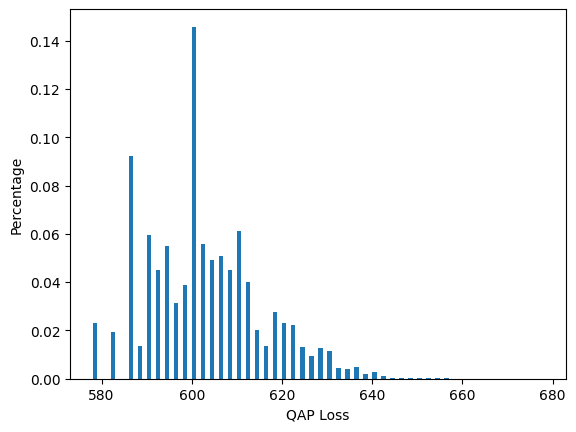

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(short_runs, density=True, bins=100)
ax.set_xlabel('QAP Loss')
ax.set_ylabel('Percentage')
ax.legend().remove()

plt.show()

### 3) Sprawdź ile jest "sukcesów" (rozwiązanie q lepsze niż rozwiązanie p) i "akceptowanych porażek" (rozwiązanie q gorsze niż rozwiązanie p, ale zaakceptowane) w kolejnych iteracjach algorytmu SA (w miarę upływu czasu, "sukcesy" i "akceptowalne porażki" są coraz rzadsze) dla kilku wybranych ustawień parametrów algorytmu. Zilustruj to zjawisko wykresem.

In [13]:
def simulate_annealing_with_success_counting(n, T, radius, alpha, loss, verbose=0):
    p = np.random.permutation(n)
    p_cost = loss(p)
    costs = np.zeros(T)
    successes = [0]
    accepted_failures = [0]
    for t in trange(T, disable=(verbose==0)):
        q = random_neighbor(p, radius)
        q_cost = loss(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            successes.append(successes[-1]+1)
            accepted_failures.append(accepted_failures[-1])
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            successes.append(successes[-1])
            accepted_failures.append(accepted_failures[-1]+1)
        else:
            successes.append(successes[-1])
            accepted_failures.append(accepted_failures[-1])
        costs[t] = p_cost
    if verbose>1:
        print(f'Minimal loss value: {costs.min()}')

    return costs, successes, accepted_failures

#### radius=1 alpha=1.

In [62]:
_, successes_a, accepted_failues_a = simulate_annealing_with_success_counting(nug12[0], 500000, 1, 1., lambda x: qap_objective_function(x, nug12[1], nug12[2]), verbose=2)

  0%|          | 0/500000 [00:00<?, ?it/s]

Minimal loss value: 578.0


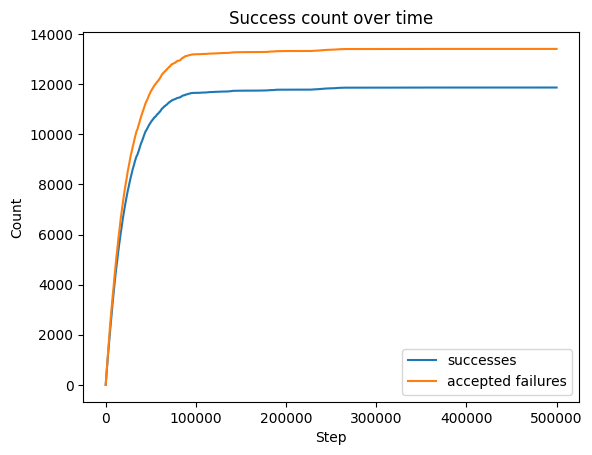

In [66]:
fig, ax = plt.subplots()

ax.plot(successes_a, label='successes')
ax.plot(accepted_failues_a, label='accepted failures')

ax.set_title('Success count over time')
ax.set_xlabel('Step')
ax.set_ylabel('Count')

ax.legend()

plt.show()

#### radius=2 alpha=1.

In [64]:
_, successes_b, accepted_failues_b = simulate_annealing_with_success_counting(nug12[0], 500000, 2, 1., lambda x: qap_objective_function(x, nug12[1], nug12[2]), verbose=2)

  0%|          | 0/500000 [00:00<?, ?it/s]

Minimal loss value: 586.0


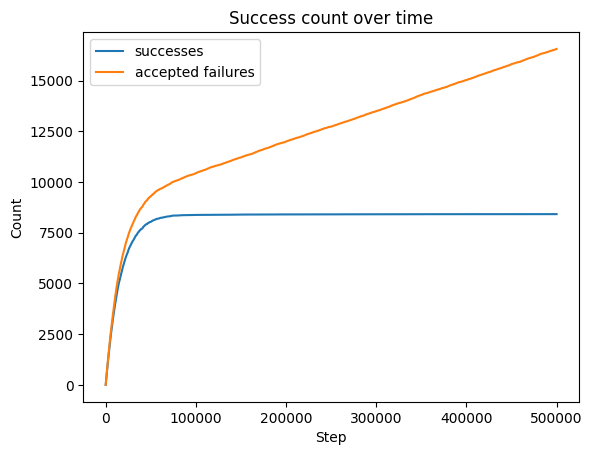

In [67]:
fig, ax = plt.subplots()

ax.plot(successes_b, label='successes')
ax.plot(accepted_failues_b, label='accepted failures')

ax.set_title('Success count over time')
ax.set_xlabel('Step')
ax.set_ylabel('Count')

ax.legend()

plt.show()

### 4)
Jak można mierzyć odległość między permutacjami? Sprawdź jaka jest zależność mmiędzy zmianami wartości funkcji celu f(p) - f(q) w sukcesach,   odległości między p
permutacjami p i q. Zilustruj to wykresem.

In [12]:
def mean_absolute_error(x, y):
    return np.abs((x-y)).mean()

def mean_squared_error(x, y):
    return np.power((x-y), 2).mean()

def hamming_distance(x, y):
    return (x!=y).sum()

def my_kendall_tau_dist(p1, p2):
  # p1, p2 are 0-based lists or np.arrays permutations
  n = len(p1)
  index_of = [None] * n  # lookup into p2
  for i in range(n):
    v = p2[i]; index_of[v] = i

  d = 0  # raw distance = number pair mis-orderings
  for i in range(n):  # scan thru p1
    for j in range(i+1, n):
      if index_of[p1[i]] > index_of[p1[j]]:  # replace "gt"
        d += 1
  normer = n * (n - 1) / 2.0  # total num pairs 
  nd = d / normer  # normalized distance
  return (d, nd)

In [11]:
def simulate_annealing_with_success_counting_and_distances(n, T, radius, alpha, loss, verbose=0):
    p = np.random.permutation(n)
    p_cost = loss(p)
    costs = []
    mae = []
    mse = []
    hamming = []
    kt = []
    nkt = []
    for t in trange(T, disable=(verbose==0)):
        q = random_neighbor(p, radius)
        q_cost = loss(q)
        if(q_cost < p_cost):
            kt_pq, nkt_pq = my_kendall_tau_dist(p, q)
            costs.append(p_cost - q_cost)
            mae.append(mean_absolute_error(p, q))
            mse.append(mean_squared_error(p, q))
            hamming.append(hamming_distance(p, q))
            kt.append(kt_pq)
            nkt.append(nkt_pq)
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
    if verbose>1:
        print(f'Minimal loss value: {min(costs)}')

    return costs, mse, mae, hamming, kt, nkt

In [138]:
costs_c, mse_c, mae_c, hamming, kt, nkt = simulate_annealing_with_success_counting_and_distances(nug12[0], 100000, 1, 1., lambda x: qap_objective_function(x, nug12[1], nug12[2]), verbose=2)

  0%|          | 0/100000 [00:00<?, ?it/s]

Minimal loss value: 2.0


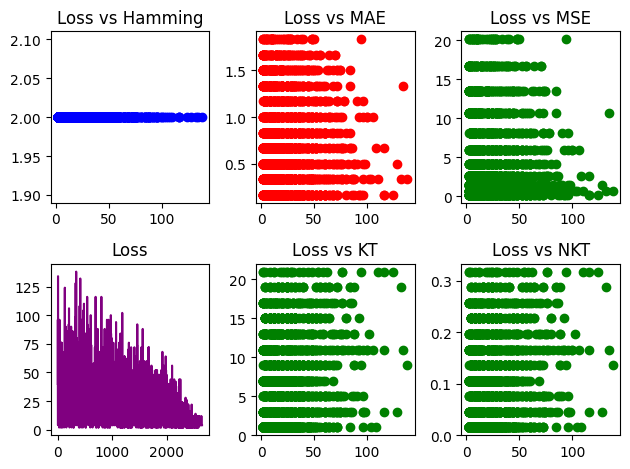

In [140]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

ax1.scatter(costs_c, hamming , color='blue')
ax2.scatter(costs_c, mae_c, color='red')
ax3.scatter(costs_c, mse_c, color='green')
ax4.plot(costs_c, color='purple', label='Objective')
ax5.scatter(costs_c, kt, color='green')
ax6.scatter(costs_c, nkt, color='green')

ax1.set_title('Loss vs Hamming')
ax2.set_title('Loss vs MAE')
ax3.set_title('Loss vs MSE')
ax4.set_title('Loss')
ax5.set_title('Loss vs KT')
ax6.set_title('Loss vs NKT')


fig.tight_layout()
plt.show()

### 5)


In [19]:
def simulate_annealing_improved(n, T, radius, alpha, loss, verbose=0):
    p = np.random.permutation(n)
    p_cost = loss(p)
    costs = np.zeros(T)
    for t in trange(T, disable=(verbose==0)):
        q = random_neighbor(p, radius)
        q_cost = loss(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T))*10**int(q_cost - p_cost<16):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    if verbose>1:
        print(f'Minimal loss value: {costs.min()}')
    return costs

def simulate_annealing_improved_min_cost(n, T, radius, alpha, loss, verbose=0):
    return simulate_annealing(n, T, radius, alpha, loss, verbose=verbose).min()

In [21]:
data_for_short_runs = download_QAP_data('https://qaplib.mgi.polymtl.ca/data.d/nug12.dat')

In [26]:
short_runs = Parallel(n_jobs=-1, verbose=1)(delayed(simulate_annealing_improved_min_cost)(data_for_short_runs[0], 500, 1, .8, lambda x: qap_objective_function(x, data_for_short_runs[1], data_for_short_runs[2]), verbose=0) for i in range(1000000))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1476 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2876 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 4676 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 6876 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 9476 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 12476 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 15876 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 19676 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 23876 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 28476 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 33476 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 38876 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 44676 ta

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


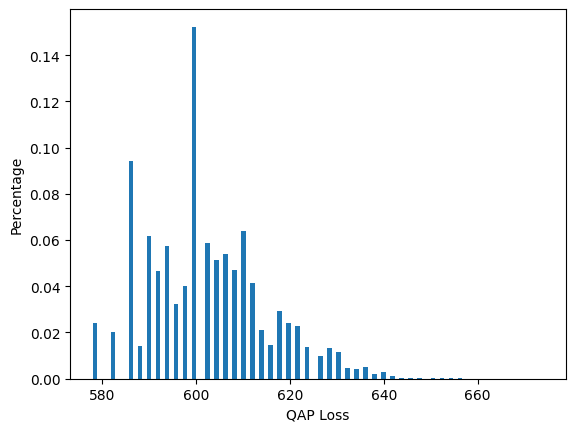

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(short_runs, density=True, bins=100)
ax.set_xlabel('QAP Loss')
ax.set_ylabel('Percentage')
ax.legend().remove()

plt.show()